In [17]:
import json

from catalyst.dl import utils
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
# from torchcontrib.optim import SWA

from constants import FilePaths, TGT_COLS
from datasets import RNAAugDatav2
from modellib import RNNmodels
from nn_trainer import get_predictions, validation_metrics


In [2]:
NUM_WORKERS = 8
BATCH_SIZE = 32  # hparams.get("batch_size", 32)
FP = FilePaths("data")

model_path = Path("logs/filter__cnnlstm__posembv3")
# folds = model_path.glob("fold_*")
# folds = [int(fold.stem.split("_")[1]) for fold in folds]
folds = [0, 1, 2, 3, 4]
with open(str(model_path / "hparams.json"), "r") as fp:
    hparams = json.load(fp)

train = pd.read_json(FP.train_json, lines=True)
cvlist = list(
    StratifiedKFold(5, shuffle=True, random_state=hparams.get("seed")).split(
        train, train["SN_filter"]
    )
)

device = utils.get_device()


In [4]:
a = np.ones(shape=(4, 2))
a[:, 1] = 2
a, a[:, [1, 0]]

(array([[1., 2.],
        [1., 2.],
        [1., 2.],
        [1., 2.]]),
 array([[2., 1.],
        [2., 1.],
        [2., 1.],
        [2., 1.]]))

In [33]:
from pytorch_geometric_dataset import prepare_dataset
from torch_geometric.data import DataLoader as GDataLoader
from gnn_trainer import add_y_cat
from modellib.graphmodel import MyDeeperGCN

add_y_cat(train)
cvlist2 = list(StratifiedKFold(5, shuffle=True, random_state=122345786).split(train, train["y_cat"]))


def get_predictions_gcn(model, loader, device):
    model.eval()
    model.to(device)
    preds = []
    with torch.no_grad():
        for data in tqdm(loader):
            data.to(device)
            bs = data.batch[-1] + 1
            b_preds = model(data)[data.test_mask]
            b_preds = b_preds.reshape(bs, -1, 3)
            b_preds = b_preds.cpu()
            b_preds = b_preds.numpy()
            preds.extend(b_preds)
        preds = np.array(preds)[:, :, [0, 2, 1]]
    return np.array(preds)


def get_gcn_preds(folds, cvlist, HPARAMS, train):
    val_preds = []
    true_preds = []
    sn_flags = []
    for fold in folds:
        val_idx = cvlist[fold][1]
        vl = train.iloc[val_idx]
        vl_ds = prepare_dataset(vl, False)
        vl_dl = GDataLoader(vl_ds, shuffle=False, batch_size=8, num_workers=4)
        model = MyDeeperGCN(
            vl_ds[0].num_node_features,
            vl_ds[0].num_edge_features,
            node_hidden_channels=HPARAMS["node_hidden_channels"],
            edge_hidden_channels=HPARAMS["edge_hidden_channels"],
            num_layers=HPARAMS["num_layers"],
            dropout1=HPARAMS["dropout1"],
            dropout2=HPARAMS["dropout2"],
            dropout3=HPARAMS["dropout3"],
            T=HPARAMS["T"],
            hidden_channels3=HPARAMS["hidden_channels3"],
            num_classes=3,
        )
        model.load_state_dict(torch.load(f"logs/gcn_model/model_state_{fold}.pt", map_location="cpu"))
        preds = get_predictions_gcn(model, vl_dl, "gpu")
        val_preds.extend(preds)
        true_preds.extend(np.dstack((np.vstack(vl[col].values) for col in TGT_COLS)))
        sn_flags.extend(vl["SN_filter"].values.astype(bool))
    return np.array(val_preds), np.array(true_preds), np.array(sn_flags)


In [29]:
HPARAMS = {
    "nb_fold": 5,
    "filter_noise": True,
    "signal_to_noise_ratio": 0.5,
    "num_epochs": 100,
    "batch_size": 8,
    "lr": 5e-4,
    "wd": 0,
    "num_layers": 10,
    "node_hidden_channels": 128,
    "edge_hidden_channels": 32,
    "dropout1": 0.1,
    "dropout2": 0.1,
    "dropout3": 0.1,
    "num_layers": 10,
    "hidden_channels3": 64,
    "T": 3,
    "add_bp_master": True,
    "add_pl_master": True,
    "add_pl_pl": True
}
val_preds5, true_preds5, sn_flags5 = get_gcn_preds([1, 2, 3, 4], cvlist2, HPARAMS, train)

100%|██████████| 60/60 [01:59<00:00,  1.99s/it]
<ipython-input-24-0d2c2a4657b8>:52: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

100%|██████████| 60/60 [01:51<00:00,  1.87s/it]


In [30]:
val_preds5.shape, true_preds5.shape

((1440, 107, 3), (1440, 68, 3))

In [31]:
eval_results = validation_metrics(true_preds5, val_preds5[:, :68, :], sn_flags5)
print(eval_results)

{'high_snr_reactivity': 0.20360028690908238, 'high_snr_deg_Mg_pH10': 0.2566712645880872, 'high_snr_deg_Mg_50C': 0.21570894345954442, 'low_snr_reactivity': 1.0277286331563482, 'low_snr_deg_Mg_pH10': 0.8857851814275922, 'low_snr_deg_Mg_50C': 1.2851696655739369, 'reactivity': 0.6218985454831267, 'deg_Mg_pH10': 0.5571801967047846, 'deg_Mg_50C': 0.7698835386478782, 'total_mcrmse': 0.6496540936119298, 'high_snr_mcrmse': 0.225326831652238, 'low_snr_mcrmse': 1.0662278267192924}


In [32]:
def get_val_preds(folds, cvlist, hparams, train):
    val_preds = []
    true_preds = []
    sn_flags = []
    for fold in folds:
        val_idx = cvlist[fold][1]
        vl = train.iloc[val_idx]
        vl_ds = RNAAugDatav2(vl, targets=TGT_COLS, augment_strucures=False)
        vl_dl = DataLoader(vl_ds, shuffle=False, drop_last=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        model = getattr(RNNmodels, hparams.get("model_name", "RNAGRUModelv3"))(hparams)
        model.load_state_dict(torch.load(model_path / f"fold_{fold}" / "checkpoints/best.pth")["model_state_dict"])
        preds = get_predictions(model, vl_dl, device)
        val_preds.extend(preds[:, :, : hparams["num_features"]])
        true_preds.extend(np.dstack((np.vstack(vl[col].values) for col in TGT_COLS)))
        sn_flags.extend(vl["SN_filter"].values.astype(bool))
    return np.array(val_preds), np.array(true_preds), np.array(sn_flags)

val_preds1, true_preds, sn_flags = get_val_preds(folds, cvlist, hparams, train)
eval_results = validation_metrics(true_preds, val_preds1, sn_flags)
print(eval_results)

/home/mohsin_okcredit_in/projects/standford-covid-vaccine-kaggle/datasets.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/mohsin_okcredit_in/projects/standford-covid-vaccine-kaggle/datasets.py:181: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

100%|██████████| 15/15 [00:03<00:00,  4.47it/s]
<ipython-input-32-d999efb7d0b2>:14: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

100%|██████████| 15/15 [00:03<

{'high_snr_reactivity': 0.1905833862504503, 'high_snr_deg_Mg_pH10': 0.24332790586205372, 'high_snr_deg_Mg_50C': 0.20113309796245302, 'low_snr_reactivity': 1.0199495174715623, 'low_snr_deg_Mg_pH10': 0.8908970259160407, 'low_snr_deg_Mg_50C': 1.2654792706502962, 'reactivity': 0.612847378647991, 'deg_Mg_pH10': 0.5544407616816625, 'deg_Mg_50C': 0.7536158062923733, 'total_mcrmse': 0.6403013155406755, 'high_snr_mcrmse': 0.21168146335831903, 'low_snr_mcrmse': 1.0587752713459664}


In [5]:
model_path = Path("logs/filter__cnnlstm__posembv5")
# folds = model_path.glob("fold_*")
# folds = [int(fold.stem.split("_")[1]) for fold in folds]
folds = [0, 1, 2, 3, 4]
with open(str(model_path / "hparams.json"), "r") as fp:
    hparams = json.load(fp)

val_preds2, true_preds, sn_flags = get_val_preds(folds, cvlist, hparams, train)

100%|██████████| 15/15 [00:03<00:00,  4.64it/s]
<ipython-input-3-e9acce519ff4>:13: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

100%|██████████| 15/15 [00:03<00:00,  4.93it/s]


In [6]:
model_path = Path("logs/filter__cnnlstm__combinedconv6/")
# folds = model_path.glob("fold_*")
# folds = [int(fold.stem.split("_")[1]) for fold in folds]
folds = [0, 1, 2, 3, 4]
with open(str(model_path / "hparams.json"), "r") as fp:
    hparams = json.load(fp)

val_preds3, true_preds, sn_flags = get_val_preds(folds, cvlist, hparams, train)

100%|██████████| 15/15 [00:03<00:00,  4.54it/s]
<ipython-input-3-e9acce519ff4>:13: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


In [7]:
model_path = Path("logs/filter__cnnlstm__mcmsre/")
# folds = model_path.glob("fold_*")
# folds = [int(fold.stem.split("_")[1]) for fold in folds]
folds = [0, 1, 2, 3, 4]
with open(str(model_path / "hparams.json"), "r") as fp:
    hparams = json.load(fp)

val_preds4, true_preds, sn_flags = get_val_preds(folds, cvlist, hparams, train)
eval_results = validation_metrics(true_preds, val_preds4, sn_flags)
print(eval_results)

100%|██████████| 15/15 [00:03<00:00,  4.03it/s]
<ipython-input-3-e9acce519ff4>:13: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


{'high_snr_reactivity': 0.19289308529643573, 'high_snr_deg_Mg_pH10': 0.24367255303217233, 'high_snr_deg_Mg_50C': 0.2023337190441839, 'low_snr_reactivity': 1.0204350097836692, 'low_snr_deg_Mg_pH10': 0.8903349320299623, 'low_snr_deg_Mg_50C': 1.2624099655646859, 'reactivity': 0.6135984550370494, 'deg_Mg_pH10': 0.5542358303989348, 'deg_Mg_50C': 0.7520875311883221, 'total_mcrmse': 0.6399739388747688, 'high_snr_mcrmse': 0.2129664524575973, 'low_snr_mcrmse': 1.0577266357927726}


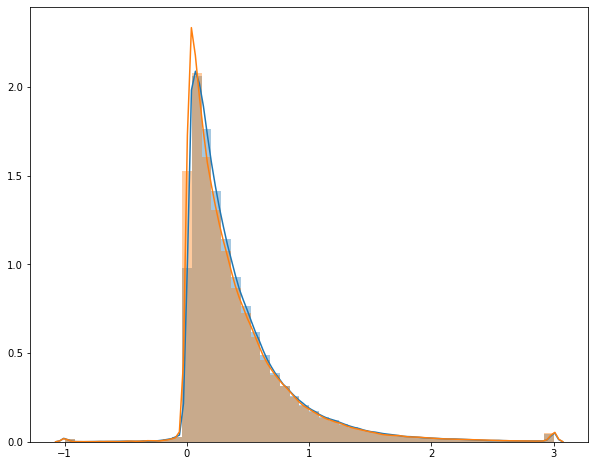

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.distplot(val_preds2.clip(-1, 3))
sns.distplot(val_preds4.clip(-1, 3))

In [9]:
eval_results = validation_metrics(true_preds, 0.25*val_preds1 + 0.25*val_preds2 + 0.25*val_preds3 + 0.25*val_preds4, sn_flags)
eval_results

{'high_snr_reactivity': 0.1831247533832897,
 'high_snr_deg_Mg_pH10': 0.2337602558744007,
 'high_snr_deg_Mg_50C': 0.19268964715639253,
 'low_snr_reactivity': 1.0185070035841162,
 'low_snr_deg_Mg_pH10': 0.887784155381371,
 'low_snr_deg_Mg_50C': 1.261579793855002,
 'reactivity': 0.6105266626085191,
 'deg_Mg_pH10': 0.5500103870768538,
 'deg_Mg_50C': 0.7499368690769224,
 'total_mcrmse': 0.6368246395874317,
 'high_snr_mcrmse': 0.20319155213802764,
 'low_snr_mcrmse': 1.0559569842734964}

In [10]:
eval_results = validation_metrics(true_preds, val_preds1, sn_flags)
print(eval_results)

{'high_snr_reactivity': 0.19058338623653248, 'high_snr_deg_Mg_pH10': 0.24332790586632091, 'high_snr_deg_Mg_50C': 0.20113309799750037, 'low_snr_reactivity': 1.019949517488303, 'low_snr_deg_Mg_pH10': 0.8908970259113832, 'low_snr_deg_Mg_50C': 1.2654792706490383, 'reactivity': 0.6128473786545402, 'deg_Mg_pH10': 0.5544407616803733, 'deg_Mg_50C': 0.7536158062978524, 'total_mcrmse': 0.6403013155442553, 'high_snr_mcrmse': 0.2116814633667846, 'low_snr_mcrmse': 1.0587752713495748}


In [11]:
eval_results = validation_metrics(true_preds, val_preds2, sn_flags)
print(eval_results)

{'high_snr_reactivity': 0.19085139931998235, 'high_snr_deg_Mg_pH10': 0.24121200399365753, 'high_snr_deg_Mg_50C': 0.20052853351058975, 'low_snr_reactivity': 1.0194442935615515, 'low_snr_deg_Mg_pH10': 0.8924958603671034, 'low_snr_deg_Mg_50C': 1.2622400497590156, 'reactivity': 0.6126184957682276, 'deg_Mg_pH10': 0.5546974700756073, 'deg_Mg_50C': 0.7516709396766943, 'total_mcrmse': 0.6396623018401765, 'high_snr_mcrmse': 0.21086397894140987, 'low_snr_mcrmse': 1.0580600678958902}


In [12]:
eval_results = validation_metrics(true_preds, val_preds3, sn_flags)
print(eval_results)

{'high_snr_reactivity': 0.19254418445697627, 'high_snr_deg_Mg_pH10': 0.24387179709248244, 'high_snr_deg_Mg_50C': 0.20112398089808387, 'low_snr_reactivity': 1.0228021932831923, 'low_snr_deg_Mg_pH10': 0.8892629943747263, 'low_snr_deg_Mg_50C': 1.2651929812628646, 'reactivity': 0.6148564343666042, 'deg_Mg_pH10': 0.5537120684585873, 'deg_Mg_50C': 0.7534517457571273, 'total_mcrmse': 0.6406734161941062, 'high_snr_mcrmse': 0.21251332081584753, 'low_snr_mcrmse': 1.0590860563069278}


In [13]:
val_preds = 0.33*val_preds1 + 0.34*val_preds2 + 0.33*val_preds3
eval_results = validation_metrics(true_preds, val_preds, sn_flags)
print(eval_results)

{'high_snr_reactivity': 0.18452470617026645, 'high_snr_deg_Mg_pH10': 0.235435825061864, 'high_snr_deg_Mg_50C': 0.19402843622769822, 'low_snr_reactivity': 1.0188871958676524, 'low_snr_deg_Mg_pH10': 0.8884350400404724, 'low_snr_deg_Mg_50C': 1.2625850282152404, 'reactivity': 0.6110199059359241, 'deg_Mg_pH10': 0.5508380945479845, 'deg_Mg_50C': 0.7507366466777983, 'total_mcrmse': 0.6375315490539023, 'high_snr_mcrmse': 0.20466298915327621, 'low_snr_mcrmse': 1.0566357547077885}


In [19]:
test = pd.read_csv("data/submission_filter__cnnlstm__posembv3.csv")

In [20]:
test.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_Mg_50C,deg_pH10,deg_50C
0,id_00073f8be_0,0.683116,0.616631,0.520960,-0.034667,0.004661
1,id_00073f8be_1,2.363307,2.824034,2.972511,-0.030310,0.058409
2,id_00073f8be_2,1.549000,0.496830,0.633059,-0.036957,0.056669
3,id_00073f8be_3,1.179283,0.943883,1.441261,-0.028975,0.065697
4,id_00073f8be_4,0.726645,0.511703,0.771562,-0.022503,0.053199


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

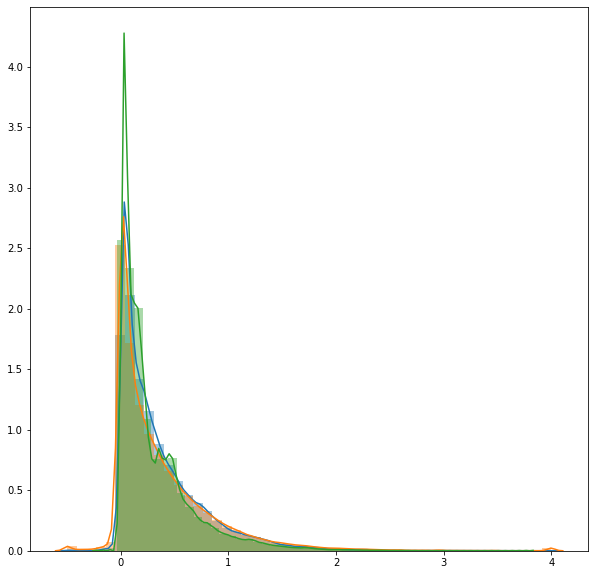

In [13]:
plt.figure(figsize=(10, 10))
sns.distplot(val_preds[:, :, 0].clip(-0.5, 4))
sns.distplot(true_preds[:, :, 0].clip(-0.5, 4))
sns.distplot(test.reactivity.values.clip(-0.5, 4))

In [13]:
test.loc[(test.reactivity > 0.5) & (test.reactivity < 0.8)].head(20)

,id_seqpos,reactivity,deg_Mg_pH10,deg_Mg_50C,deg_pH10,deg_50C
0,id_00073f8be_0,0.683116,0.616631,0.520960,-0.034667,0.004661
4,id_00073f8be_4,0.726645,0.511703,0.771562,-0.022503,0.053199
5,id_00073f8be_5,0.607097,0.495142,0.664396,-0.026971,0.044734
6,id_00073f8be_6,0.797827,0.941696,1.083660,-0.025002,0.048043
7,id_00073f8be_7,0.768930,0.907591,0.958304,-0.023656,0.047586
15,id_00073f8be_15,0.683961,0.444687,0.382860,-0.021074,0.038887
16,id_00073f8be_16,0.775914,0.594282,0.477709,-0.019180,0.045744
22,id_00073f8be_22,0.795498,0.670959,0.282275,-0.019561,0.025371
23,id_00073f8be_23,0.729013,0.294134,0.268629,-0.029782,0.036259
33,id_00073f8be_33,0.568767,0.200895,0.153787,-0.038339,0.036955


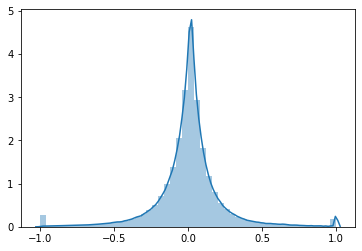

In [16]:
sns.distplot((val_preds - true_preds).clip(-1, 1))

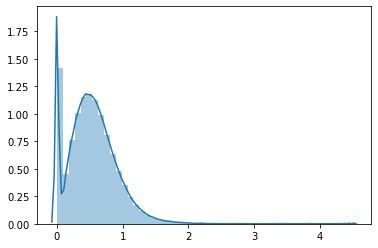

In [17]:
sns.distplot(np.sqrt(true_preds.clip(0, 20)))

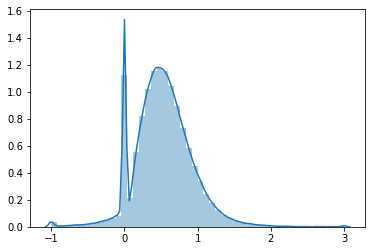

In [25]:
y_sqrt = np.sign(true_preds) * np.sqrt(np.abs(true_preds))
sns.distplot(y_sqrt.clip(-1, 3))

In [21]:
import torch
torch.sign(torch.tensor(-2))

tensor(-1)

In [22]:
a=np.array([1.222222222222223456, 2.3678999999999999877765])

In [23]:
a.astype('float32')

array([1.2222222, 2.3679   ], dtype=float32)

In [24]:
a[0]

1.2222222222222234